In [1]:
!pip install tensorflow

     -------------------------------------- 272.8/272.8 MB 3.4 MB/s eta 0:00:00
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
     ---------------------------------------- 4.1/4.1 MB 9.7 MB/s eta 0:00:00
  Using cached termcolor-2.3.0-py3-none-any.whl (6.9 kB)
     ---------------------------------------- 1.5/1.5 MB 8.6 MB/s eta 0:00:00
  Using cached tensorflow_estimator-2.12.0-py2.py3-none-any.whl (440 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached absl_py-1.4.0-py3-none-any.whl (126 kB)
     --------------------------------------- 14.7/14.7 MB 10.6 MB/s eta 0:00:00
  Using cached libclang-16.0.0-py2.py3-none-win_amd64.whl (24.4 MB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached keras-2.12.0-py2.py3-none-any.whl (1.7 MB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
     -------------------------------------- 422.5/422.5 kB 5.3 MB/s eta 0:00:00
  Using cached flatbuffers-23.5.9-py2.py3-none-any.whl (26 kB)
 

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\ProgramData\\Anaconda3\\Lib\\site-packages\\~umpy\\core\\_multiarray_tests.cp39-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [3]:
!pip install tensorflow
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

  Using cached tensorflow-2.12.0-cp39-cp39-win_amd64.whl (1.9 kB)
  Using cached tensorflow_intel-2.12.0-cp39-cp39-win_amd64.whl (272.8 MB)
  Using cached absl_py-1.4.0-py3-none-any.whl (126 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached keras-2.12.0-py2.py3-none-any.whl (1.7 MB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached grpcio-1.54.2-cp39-cp39-win_amd64.whl (4.1 MB)
  Using cached tensorboard-2.12.3-py3-none-any.whl (5.6 MB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached jax-0.4.10-py3-none-any.whl
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached ml_dtypes-0.1.0-cp39-cp39-win_amd64.whl (120 kB)
  Using cached google_auth_oauthlib-1.0.0-py2.py3-none-any.whl (18 kB)
  Using cached google_auth-2.18.1-py2.py3-none-any.whl (178 kB)
  Using cached cachetools-5.3.0-py3-none-any.whl (9.3 kB)
  Using cached requests_oauthlib-1.3.1-py2.py3-none-any.whl (23 kB)
modules loaded


In [6]:
data_dir = 'C:/Users/Administrator/Desktop/fruit'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [7]:
df

,filepaths,labels
0,C:/Users/Administrator/Desktop/fruit\Anthracno...,Anthracnose
1,C:/Users/Administrator/Desktop/fruit\Anthracno...,Anthracnose
2,C:/Users/Administrator/Desktop/fruit\Anthracno...,Anthracnose
3,C:/Users/Administrator/Desktop/fruit\Anthracno...,Anthracnose
4,C:/Users/Administrator/Desktop/fruit\Anthracno...,Anthracnose
...,...,...
3995,C:/Users/Administrator/Desktop/fruit\Sooty Mou...,Sooty Mould
3996,C:/Users/Administrator/Desktop/fruit\Sooty Mou...,Sooty Mould
3997,C:/Users/Administrator/Desktop/fruit\Sooty Mou...,Sooty Mould
3998,C:/Users/Administrator/Desktop/fruit\Sooty Mou...,Sooty Mould


In [8]:
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

In [9]:
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Recommended : use custom function for test data batch size, else we can use normal batch size.
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# This function which will be used in image data generator for data augmentation, it just take the image and return it again.
def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar)
ts_gen = ImageDataGenerator(preprocessing_function= scalar)

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)

Found 3200 validated image filenames belonging to 8 classes.
Found 480 validated image filenames belonging to 8 classes.
Found 320 validated image filenames belonging to 8 classes.


In [10]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.ResNet50(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation=None
)

base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

102967424/102967424 [==============================] - 8s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1000)              25636712  
                                                                 
 batch_normalization (BatchN  (None, 1000)             4000      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               256256    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 25,899,024
Trainable params: 260,312
Non-

In [11]:
batch_size = 16   # set batch size for training
epochs = 35   # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, validation_steps= None, shuffle= False)

Epoch 1/35
200/200 [==============================] - 242s 1s/step - loss: 6.5709 - accuracy: 0.8719 - val_loss: 5.2622 - val_accuracy: 0.9812
Epoch 2/35
200/200 [==============================] - 241s 1s/step - loss: 4.4477 - accuracy: 0.9644 - val_loss: 3.6342 - val_accuracy: 0.9771
Epoch 3/35
200/200 [==============================] - 241s 1s/step - loss: 3.0692 - accuracy: 0.9769 - val_loss: 2.4710 - val_accuracy: 0.9792
Epoch 4/35
200/200 [==============================] - 241s 1s/step - loss: 2.0814 - accuracy: 0.9856 - val_loss: 1.6679 - val_accuracy: 0.9875
Epoch 5/35
200/200 [==============================] - 237s 1s/step - loss: 1.4301 - accuracy: 0.9822 - val_loss: 1.1497 - val_accuracy: 0.9875
Epoch 6/35
200/200 [==============================] - 235s 1s/step - loss: 1.0095 - accuracy: 0.9881 - val_loss: 0.8269 - val_accuracy: 0.9875
Epoch 7/35
200/200 [==============================] - 235s 1s/step - loss: 0.7529 - accuracy: 0.9891 - val_loss: 0.6279 - val_accuracy: 0.9896

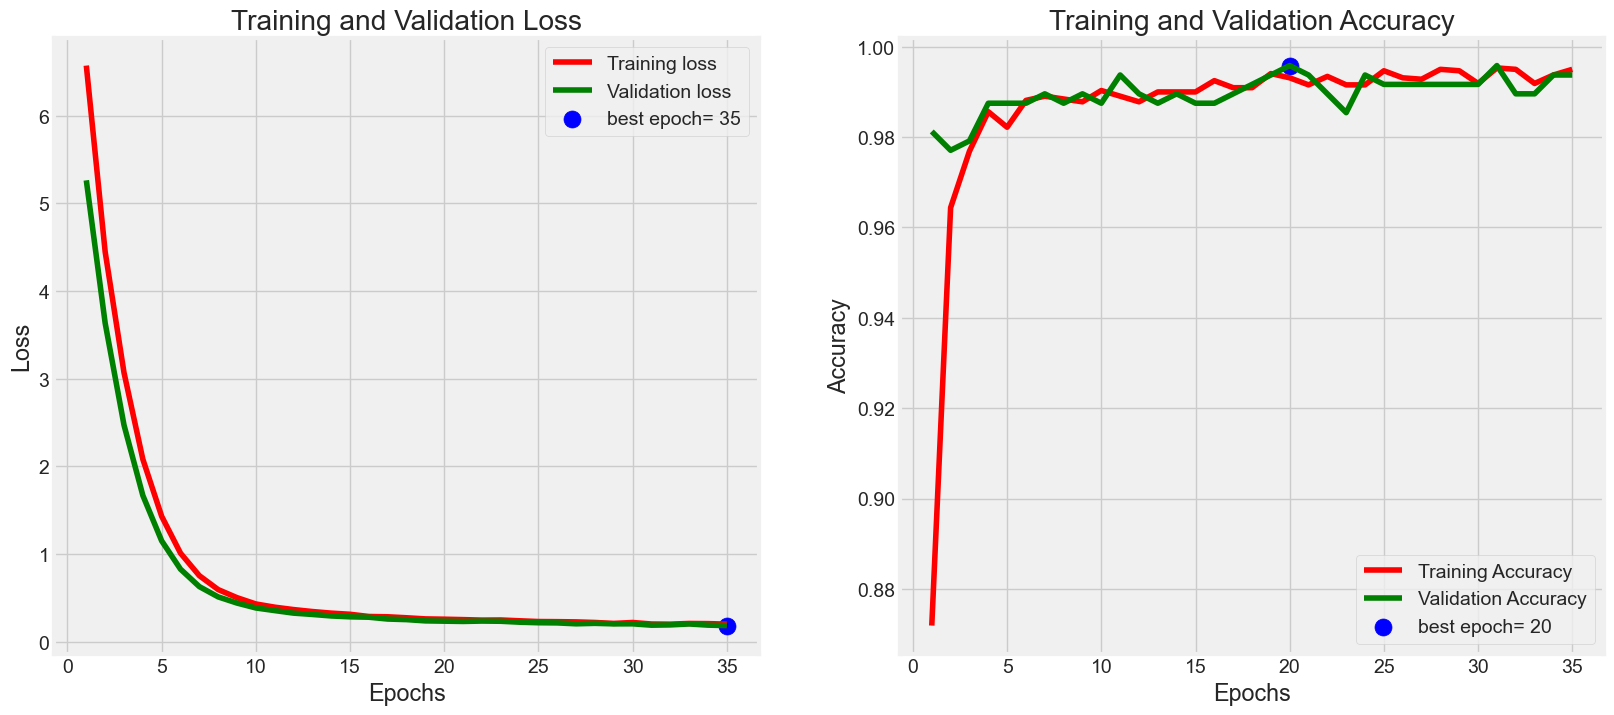

In [12]:
 tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [13]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

4/4 [==============================] - 20s 5s/step - loss: 0.2002 - accuracy: 0.9875
Train Loss:  0.1616441309452057
Train Accuracy:  1.0
--------------------
Validation Loss:  0.18390215933322906
Validation Accuracy:  1.0
--------------------
Test Loss:  0.2002410888671875
Test Accuracy:  0.987500011920929


In [14]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

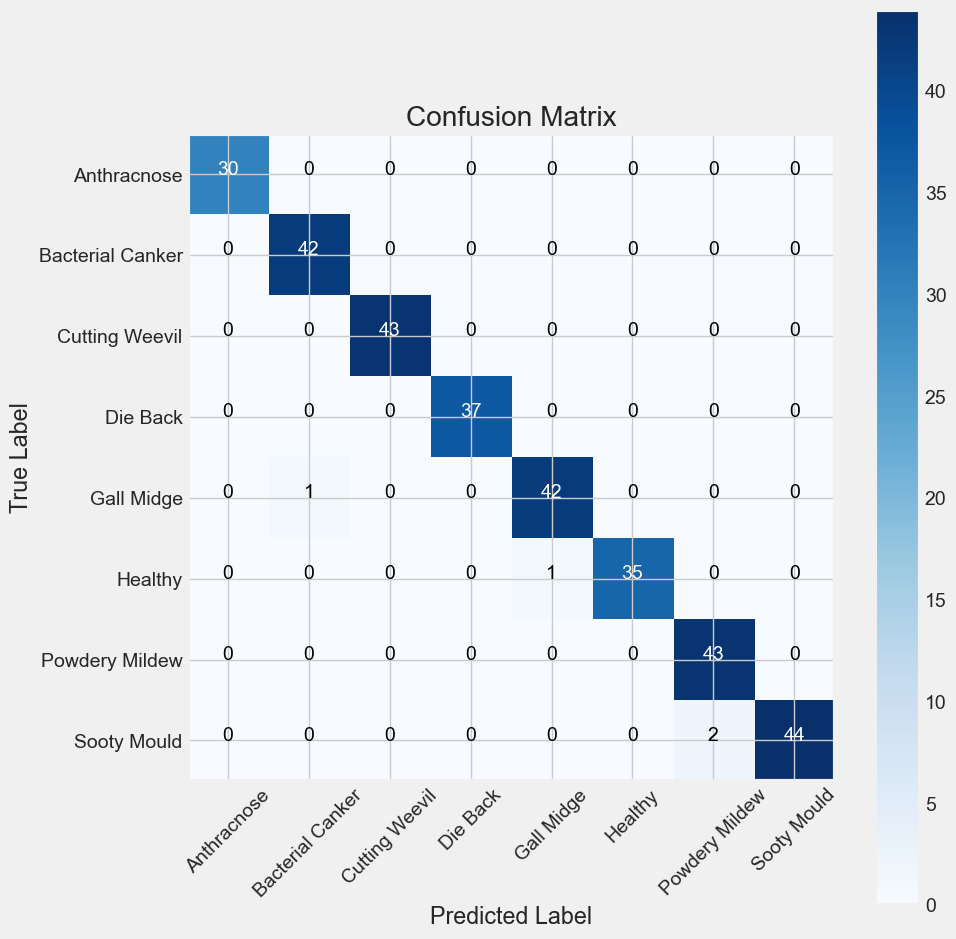

In [15]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [16]:
from sklearn.metrics import precision_score, recall_score

# Calculate precision
precision = precision_score(test_gen.classes, y_pred, average='weighted')

# Calculate recall
recall = recall_score(test_gen.classes, y_pred, average='weighted')

print("Precision: ", precision)
print("Recall: ", recall)

Precision:  0.9878504521963825
Recall:  0.9875
